#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, datasets, preprocessing, svm, linear_model
from sklearn.grid_search import GridSearchCV
import re
import os
import string
import io, os, sys, types
from findMyNotebook import find_notebook
import findMyNotebook
from DataFiltering import NumericalizeData    #see DataFiltering.ipynb (yes, it is a python notebook!!)

importing notebook from DataFiltering.ipynb


#### Load Data Set

In [2]:
uciData_path='/Users/yogeshluthra/Documents/OneDrive/OMCS GeorgiaTech/Machine Learning/UCI_datasets'

#currData=re.escape('crx.data')
currData='german.data'

df=pd.read_csv(uciData_path+'/'+currData, sep='[,\t\s]+', header=None, engine='python')
attributes=['A'+str(colnum) for colnum in range(1,len(df.columns))]
attributes.append('Label')
df.columns = attributes
print(df.head(n=3))
print("instances: "+str(len(df.index))+"\t attributes: "+str(len(df.columns)))



    A1  A2   A3   A4    A5   A6   A7  A8   A9   A10  ...    A12 A13   A14  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101  ...   A121  67  A143   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101  ...   A121  22  A143   
2  A14  12  A34  A46  2096  A61  A74   2  A93  A101  ...   A121  49  A143   

    A15 A16   A17 A18   A19   A20 Label  
0  A152   2  A173   1  A192  A201     1  
1  A152   1  A173   1  A191  A201     2  
2  A152   1  A172   2  A191  A201     1  

[3 rows x 21 columns]
instances: 1000	 attributes: 21


#### Replace missing values with np.nan

In [3]:
replacementDict={'?':np.nan, 
                 '-':np.nan}

In [4]:
df=df.replace(replacementDict)
print("Any missing values? {0}".format(df.isnull().values.any()))

Any missing values? False


#### Save data for sanity check

In [5]:
df.to_csv(uciData_path+'/'+currData+'.csv', sep=',', index=False)   #no index column. Separated by tab
print("processed csv saved in:")
print(uciData_path+'/'+currData+'.csv')

processed csv saved in:
/Users/yogeshluthra/Documents/OneDrive/OMCS GeorgiaTech/Machine Learning/UCI_datasets/german.data.csv


#### Use DataSet

In [6]:
y=df['Label'].values
X=df.ix[:,:-1].values
print("target shape: {0} \t attribute shape: {1}".format(y.shape, X.shape))

target shape: (1000,) 	 attribute shape: (1000, 20)


##### Some data usage example

In [7]:
x_curr=X[:5,0]        #creates row vector
x_curr=X[:5,[0]]      #creates col vector
x_curr=X[np.array(range(5)),:5]    #print matrix of 5x5
x_curr=X[np.array(range(5)),np.array([0,1,2,3,4])]    #diagonal slicing
print x_curr

['A11' 48 'A34' 'A42' 4870]


In [8]:
print ['c' for i in range(X.shape[1])]    # copy paste for attribute types below

['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


#### Data preprocessing
-  One-Hot encoding for categorical features  
-  Mean normalization for numerical attributes (if doNorm is True)  
-  Imputing of Nominal and Numeric attribute values
  -  If doImpute==False and removeMissing==True   remove instances with any missing missing attribute value
-  label binarization  

In [9]:
attrTypes=['c', 'n', 'c', 'c', 'n', 'c', 'c', 'n', 'c', 'c', 'n', 'c', 'n', 'c', 'c', 'n', 'c', 'n', 'c', 'c']
print "just for check"
print zip(X[0,:],attrTypes)

print("Attribute shape (before): {0}".format(X.shape))
(X, enc_num, enc_nom)=NumericalizeData(X, attrTypes)
print("Attribute shape (after): {0}".format(X.shape))

just for check
[('A11', 'c'), (6, 'n'), ('A34', 'c'), ('A43', 'c'), (1169, 'n'), ('A65', 'c'), ('A75', 'c'), (4, 'n'), ('A93', 'c'), ('A101', 'c'), (4, 'n'), ('A121', 'c'), (67, 'n'), ('A143', 'c'), ('A152', 'c'), (2, 'n'), ('A173', 'c'), (1, 'n'), ('A192', 'c'), ('A201', 'c')]
Attribute shape (before): (1000, 20)
Imputing dataset...
Attribute shape (after): (1000, 61)


In [10]:
X[0,:]

array([ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        , -1.23647786,
       -0.74513141,  0.91847717,  1.04698668,  2.76645648,  1.02707891,
       -0.42828957])

#### Train Algo

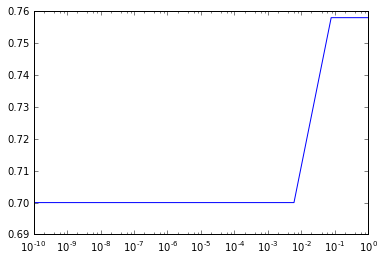

In [11]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

kfolds_strat=cross_validation.StratifiedKFold(y, n_folds=3)
score_vector=[]
for C in C_s:
    svc.C=C
    this_mean_score = np.mean(cross_validation.cross_val_score(svc, X, y, cv=kfolds_strat, n_jobs=-1))
    #this will compute score based on cross validation. Basically this FITS on train and SCORES on test (cv set) itself.
    score_vector.append(this_mean_score)
plt.semilogx(C_s, score_vector)
plt.show()